In [ ]:



!pip install shap lime xgboost tensorflow

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM

# XAI
import shap
import lime
import lime.lime_tabular


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/aiml projects/lung_cancer_dataset.csv")
print(df.head())

   patient_id  age  gender  pack_years radon_exposure asbestos_exposure  \
0      100000   69    Male   66.025244           High                No   
1      100001   32  Female   12.780800           High                No   
2      100002   89  Female    0.408278         Medium               Yes   
3      100003   78  Female   44.065232            Low                No   
4      100004   38  Female   44.432440         Medium               Yes   

  secondhand_smoke_exposure copd_diagnosis alcohol_consumption family_history  \
0                        No            Yes            Moderate             No   
1                       Yes            Yes            Moderate            Yes   
2                       Yes            Yes                 NaN             No   
3                       Yes             No            Moderate             No   
4                        No            Yes                 NaN            Yes   

  lung_cancer  
0          No  
1         Yes  
2         Yes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patient_id                 50000 non-null  int64  
 1   age                        50000 non-null  int64  
 2   gender                     50000 non-null  object 
 3   pack_years                 50000 non-null  float64
 4   radon_exposure             50000 non-null  object 
 5   asbestos_exposure          50000 non-null  object 
 6   secondhand_smoke_exposure  50000 non-null  object 
 7   copd_diagnosis             50000 non-null  object 
 8   alcohol_consumption        33338 non-null  object 
 9   family_history             50000 non-null  object 
 10  lung_cancer                50000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB
None
                             count unique     top   freq       mean  \
patient_id               

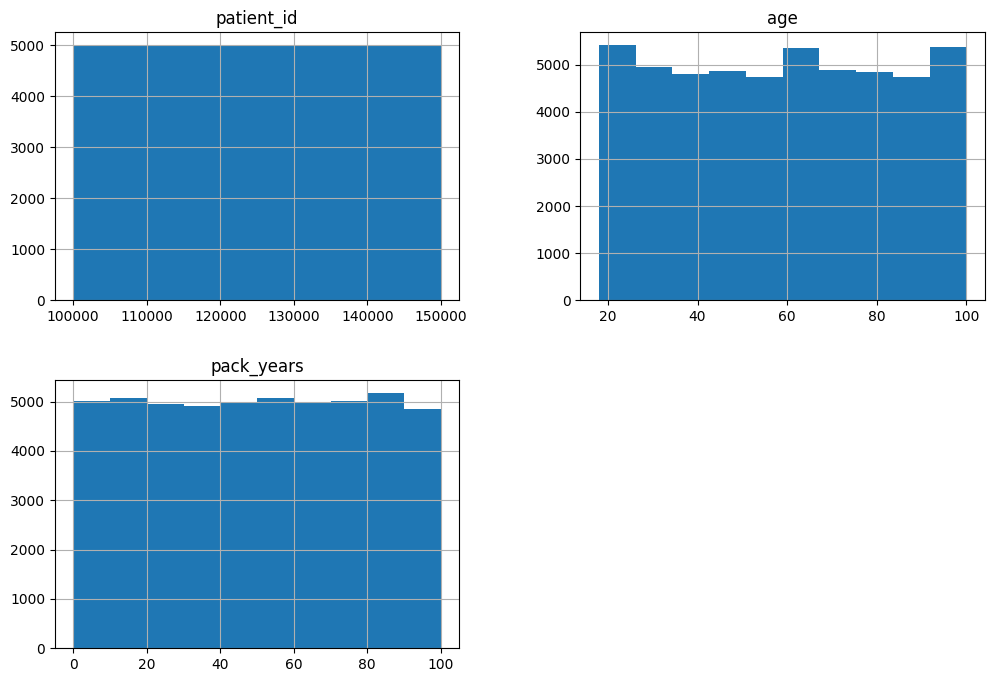

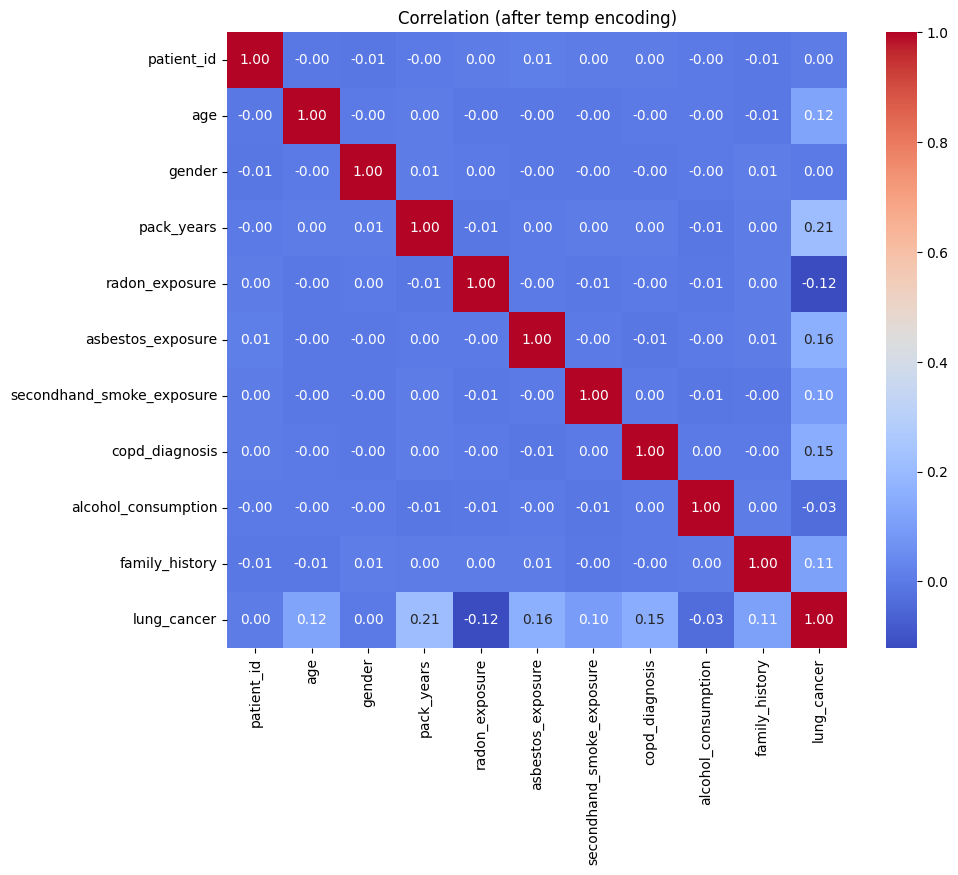

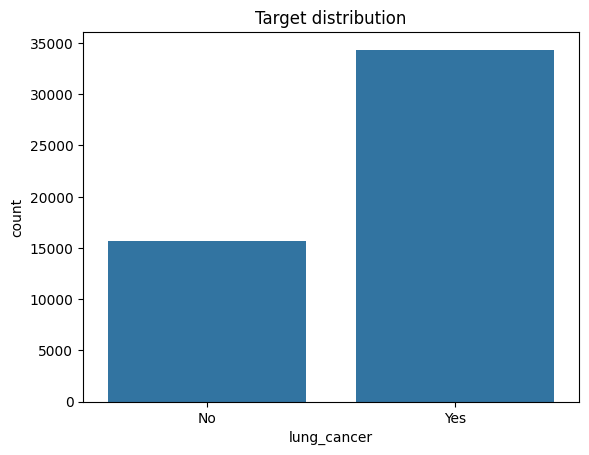

In [ ]:
# Basic info & missing values
print(df.info())
print(df.describe(include='all').T)
print("Missing:\n", df.isnull().sum())

# Distribution of numeric cols
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols].hist(figsize=(12,8)); plt.show()

# Encode categorical TEMPORARILY for correlation
df_corr = df.copy()
cat_cols = df_corr.select_dtypes(include=['object','category']).columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for c in cat_cols:
    df_corr[c] = le.fit_transform(df_corr[c].astype(str))

plt.figure(figsize=(10,8))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (after temp encoding)"); plt.show()

# Target distribution
target_col = 'lung_cancer'   # CHANGE if your target has a different name
sns.countplot(x=target_col, data=df); plt.title("Target distribution"); plt.show()



In [ ]:
# 5.1 Map common Yes/No and Male/Female to 1/0 (if present)
map_dict = {'Yes':1, 'No':0, 'Male':1, 'Female':0}
df = df.replace(map_dict)

# 5.2 If still categorical, LabelEncode them
for c in df.select_dtypes(include=['object']).columns:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

# 5.3 Handle missing values (simple imputer: numeric -> median)
imputer = SimpleImputer(strategy='median')
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = imputer.fit_transform(df[num_cols])

# 5.4 Remove duplicate rows (optional)
df = df.drop_duplicates()

# 5.5 Final check
print(df.info())
print("Any missing left?\n", df.isnull().sum().sum())


/tmp/ipython-input-1172512963.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(map_dict)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patient_id                 50000 non-null  float64
 1   age                        50000 non-null  float64
 2   gender                     50000 non-null  float64
 3   pack_years                 50000 non-null  float64
 4   radon_exposure             50000 non-null  float64
 5   asbestos_exposure          50000 non-null  float64
 6   secondhand_smoke_exposure  50000 non-null  float64
 7   copd_diagnosis             50000 non-null  float64
 8   alcohol_consumption        50000 non-null  float64
 9   family_history             50000 non-null  float64
 10  lung_cancer                50000 non-null  float64
dtypes: float64(11)
memory usage: 4.2 MB
None
Any missing left?
 0


In [ ]:
# ===============================
# STEP 6: Split, Scale, Balance
# ===============================

# 👇 Make sure target_col is correct in your dataset
print("Columns available:", df.columns.tolist())

target_col = "lung_cancer"   # CHANGE if your target has a different name
# e.g., 'LUNG_CANCER_RISK'

X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split (80-20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Balance dataset using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_train_res))


Columns available: ['patient_id', 'age', 'gender', 'pack_years', 'radon_exposure', 'asbestos_exposure', 'secondhand_smoke_exposure', 'copd_diagnosis', 'alcohol_consumption', 'family_history', 'lung_cancer']
Before SMOTE: [12509 27491]
After SMOTE : [27491 27491]


In [ ]:
# ===============================
# STEP 7: Train ML Models
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# Store results
results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)   # Train on balanced data
    y_pred = model.predict(X_test_scaled)   # Test predictions
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")

    results.append([name, acc, prec, rec, f1, roc])

    print(f"\n{name} Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

# Create a DataFrame of results
ml_results = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC-AUC"])
ml_results.sort_values(by="F1", ascending=False)



Logistic Regression Report:

              precision    recall  f1-score   support

         0.0       0.48      0.68      0.56      3127
         1.0       0.82      0.67      0.74      6873

    accuracy                           0.67     10000
   macro avg       0.65      0.67      0.65     10000
weighted avg       0.71      0.67      0.68     10000


Decision Tree Report:

              precision    recall  f1-score   support

         0.0       0.42      0.52      0.46      3127
         1.0       0.75      0.68      0.71      6873

    accuracy                           0.63     10000
   macro avg       0.59      0.60      0.59     10000
weighted avg       0.65      0.63      0.63     10000


Random Forest Report:

              precision    recall  f1-score   support

         0.0       0.50      0.56      0.53      3127
         1.0       0.79      0.74      0.76      6873

    accuracy                           0.69     10000
   macro avg       0.64      0.65      0.65     10

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:51:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Report:

              precision    recall  f1-score   support

         0.0       0.52      0.60      0.56      3127
         1.0       0.80      0.75      0.77      6873

    accuracy                           0.70     10000
   macro avg       0.66      0.67      0.67     10000
weighted avg       0.71      0.70      0.71     10000



,Model,Accuracy,Precision,Recall,F1,ROC-AUC
5,XGBoost,0.7008,0.803630,0.747272,0.774427,0.755875
2,Random Forest,0.6857,0.788879,0.741016,0.764198,0.731853
0,Logistic Regression,0.6728,0.820089,0.671177,0.738198,0.741064
3,SVM,0.6695,0.839680,0.641641,0.727423,0.749646
1,Decision Tree,0.6257,0.754306,0.675396,0.712674,0.595933
4,KNN,0.6332,0.780697,0.648480,0.708472,0.669844


In [ ]:
# ===============================
# STEP 8: Deep Learning Models
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM

# Prepare data (MLP uses normal scaled, CNN/LSTM need 3D)
Xtr = np.array(X_train_res)
Xte = np.array(X_test_scaled)
ytr = np.array(y_train_res)
yte = np.array(y_test)

Xtr_c = Xtr.reshape((Xtr.shape[0], Xtr.shape[1], 1))
Xte_c = Xte.reshape((Xte.shape[0], Xte.shape[1], 1))

# ===============================
# 1) MLP Model
# ===============================
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(Xtr.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(Xtr, ytr, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
mlp_acc = mlp.evaluate(Xte, yte, verbose=0)[1]
print("MLP Test Accuracy:", mlp_acc)

# ===============================
# 2) CNN Model
# ===============================
cnn = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(Xtr_c.shape[1],1)),
    Conv1D(64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(Xtr_c, ytr, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
cnn_acc = cnn.evaluate(Xte_c, yte, verbose=0)[1]
print("CNN Test Accuracy:", cnn_acc)

# ===============================
# 3) LSTM Model
# ===============================
lstm = Sequential([
    LSTM(64, input_shape=(Xtr_c.shape[1],1)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(Xtr_c, ytr, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
lstm_acc = lstm.evaluate(Xte_c, yte, verbose=0)[1]
print("LSTM Test Accuracy:", lstm_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6541 - loss: 0.6062 - val_accuracy: 0.6345 - val_loss: 0.6504
Epoch 2/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6850 - loss: 0.5756 - val_accuracy: 0.6092 - val_loss: 0.6703
Epoch 3/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6905 - loss: 0.5675 - val_accuracy: 0.5937 - val_loss: 0.6717
Epoch 4/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6898 - loss: 0.5688 - val_accuracy: 0.6356 - val_loss: 0.6360
Epoch 5/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6913 - loss: 0.5643 - val_accuracy: 0.6356 - val_loss: 0.6354
Epoch 6/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6922 - loss: 0.5647 - val_accuracy: 0.5805 - val_loss: 0.7085
Epoch 7/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6968 - loss: 0.5586 - val_accuracy: 0.6434 - val_loss: 0.6298
Epoch 8/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6946 - loss: 0.5632 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1547/1547 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6760 - loss: 0.5890 - val_accuracy: 0.5457 - val_loss: 0.7458
Epoch 2/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6843 - loss: 0.5711 - val_accuracy: 0.6992 - val_loss: 0.5762
Epoch 3/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6918 - loss: 0.5662 - val_accuracy: 0.5859 - val_loss: 0.6804
Epoch 4/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6904 - loss: 0.5668 - val_accuracy: 0.6607 - val_loss: 0.6207
Epoch 5/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6995 - loss: 0.5602 - val_accuracy: 0.6367 - val_loss: 0.6385
Epoch 6/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6939 - loss: 0.5583 - val_accuracy: 0.7323 - val_loss: 0.5565
Epoch 7/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6959 - loss: 0.5579 - val_accuracy: 0.6816 - val_loss: 0.5826
Epoch 8/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7013 - loss: 0.5500 - val_accurac

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1547/1547 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6048 - loss: 0.6576 - val_accuracy: 0.3790 - val_loss: 0.7915
Epoch 2/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6318 - loss: 0.6301 - val_accuracy: 0.5403 - val_loss: 0.7459
Epoch 3/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6752 - loss: 0.5835 - val_accuracy: 0.6241 - val_loss: 0.6620
Epoch 4/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6775 - loss: 0.5805 - val_accuracy: 0.6012 - val_loss: 0.6663
Epoch 5/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6819 - loss: 0.5740 - val_accuracy: 0.6643 - val_loss: 0.6108
Epoch 6/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6824 - loss: 0.5734 - val_accuracy: 0.5757 - val_loss: 0.6970
Epoch 7/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6836 - loss: 0.5728 - val_accuracy: 0.6077 - val_loss: 0.6805
Epoch 8/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6921 - loss: 0.5622 - val_a

Running SHAP...


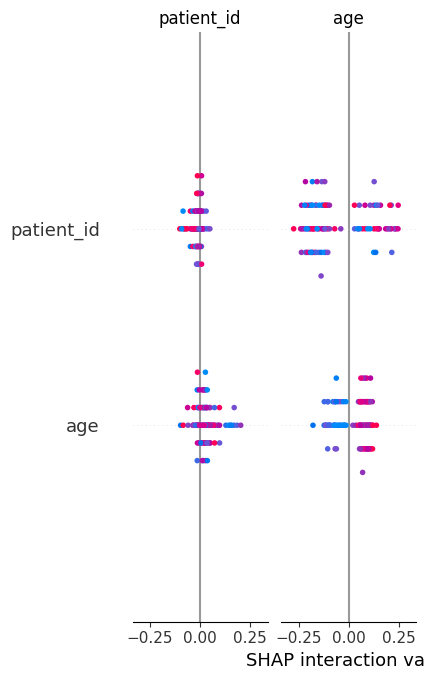

Running LIME...


Plotting Feature Importance...


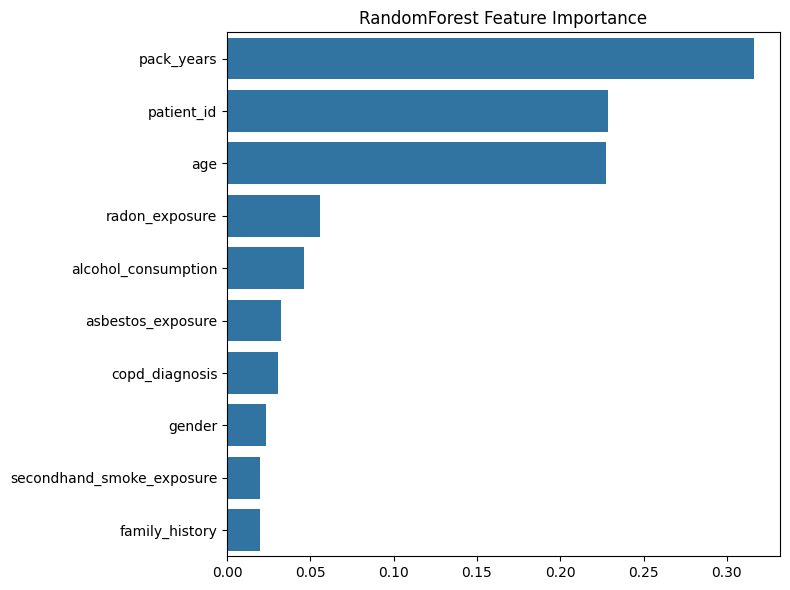

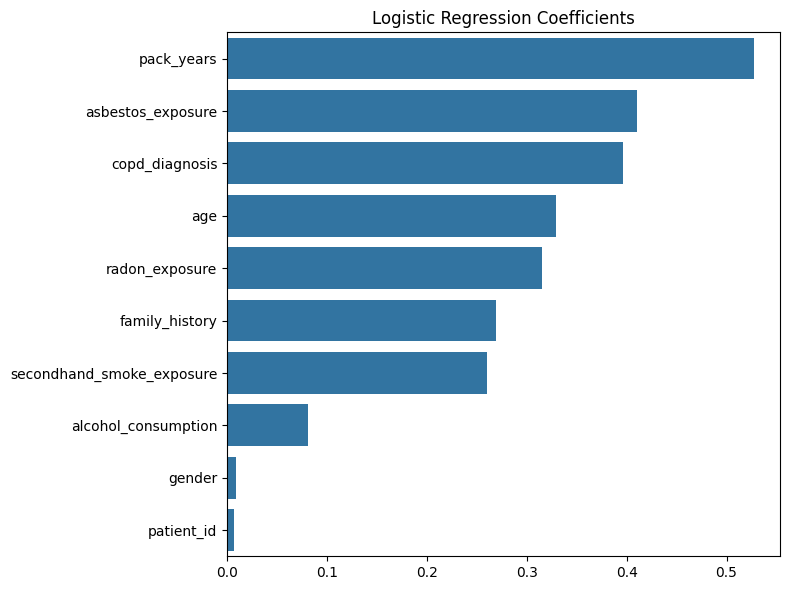

Plotting PDP & ICE...


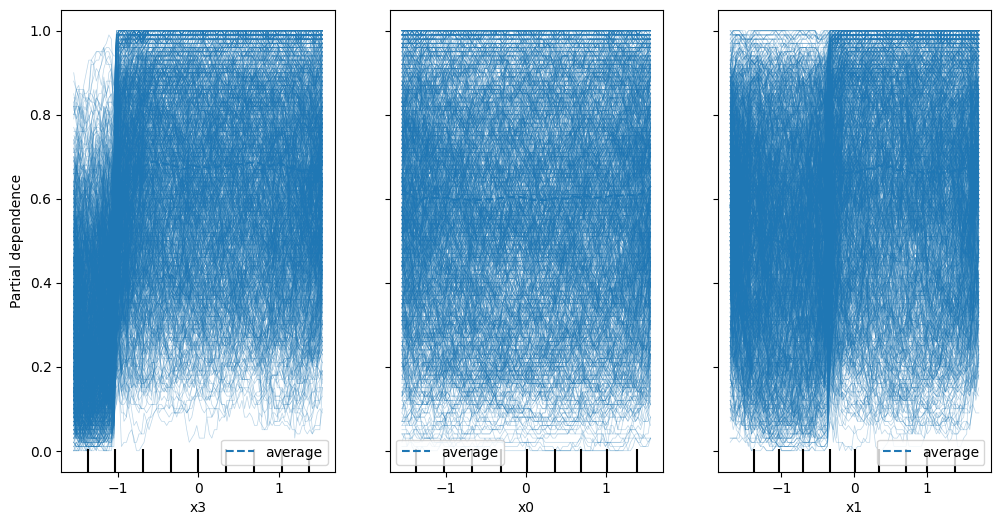

In [17]:
# ===============================
# STEP 9: Explainable AI (XAI)
# ===============================
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings("ignore")   # suppress all warnings

# Helper: ensure we always have a DataFrame for feature names
def to_dataframe(X_part, columns):
    if isinstance(X_part, np.ndarray):
        return pd.DataFrame(X_part, columns=columns)
    return X_part

# ---- SHAP for Random Forest ----
print("Running SHAP...")
rf_model = models["Random Forest"]   # trained earlier

# Use a small sample of X_test for speed
X_sample = Xte[:100]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

# Plot SHAP summary
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)

# ---- LIME for one prediction ----
print("Running LIME...")
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=to_dataframe(Xtr, X.columns).values,
    feature_names=X.columns.tolist(),
    class_names=['No Cancer','Cancer'],
    mode='classification'
)

# Explain the first test sample
i = 0
exp = explainer_lime.explain_instance(
    Xte[i],
    rf_model.predict_proba,
    num_features=8
)
exp.show_in_notebook(show_table=True)

# ---- Feature Importance ----
print("Plotting Feature Importance...")

def plot_feature_importance(model, feature_names, top_n=15, title="Feature Importance"):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):  # e.g., Logistic Regression
        importance = np.abs(model.coef_[0])
    else:
        print("Model has no feature importance attribute.")
        return

    idx = np.argsort(importance)[::-1][:top_n]
    plt.figure(figsize=(8,6))
    sns.barplot(x=importance[idx], y=np.array(feature_names)[idx])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# RandomForest Feature Importance
plot_feature_importance(rf_model, X.columns, title="RandomForest Feature Importance")

# Logistic Regression Feature Importance
log_model = models["Logistic Regression"]
plot_feature_importance(log_model, X.columns, title="Logistic Regression Coefficients")

# ---- PDP & ICE ----
print("Plotting PDP & ICE...")
importances = rf_model.feature_importances_
top_idx = np.argsort(importances)[::-1][:3]  # top 3 features (indices)

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf_model,
    Xte,                  # NumPy array → no warnings
    features=top_idx,     # indices instead of names
    kind="both",
    ax=ax
)
plt.show()
